<a href="https://colab.research.google.com/github/polizzilab/NISE/blob/main/NISE_LASErMPNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0) Install LASErMPNN & Boltz-2 for NISE protocol

<MARK> DO NOT HIT `RUN ALL` OR THE RUNTIME WILL CRASH </MARK>. Run the cells one at at time.

### Preliminary Setup:

___

***Go to the following link and follow the steps depicted below:***

https://drive.google.com/drive/folders/16Ifjy_7BbKIGxal4vY9EODX-FEJIHPuh?usp=drive_link

___

### Step 1: Click on parent folder called `boltz` and select `Organize` -> `Add Shortcut`.


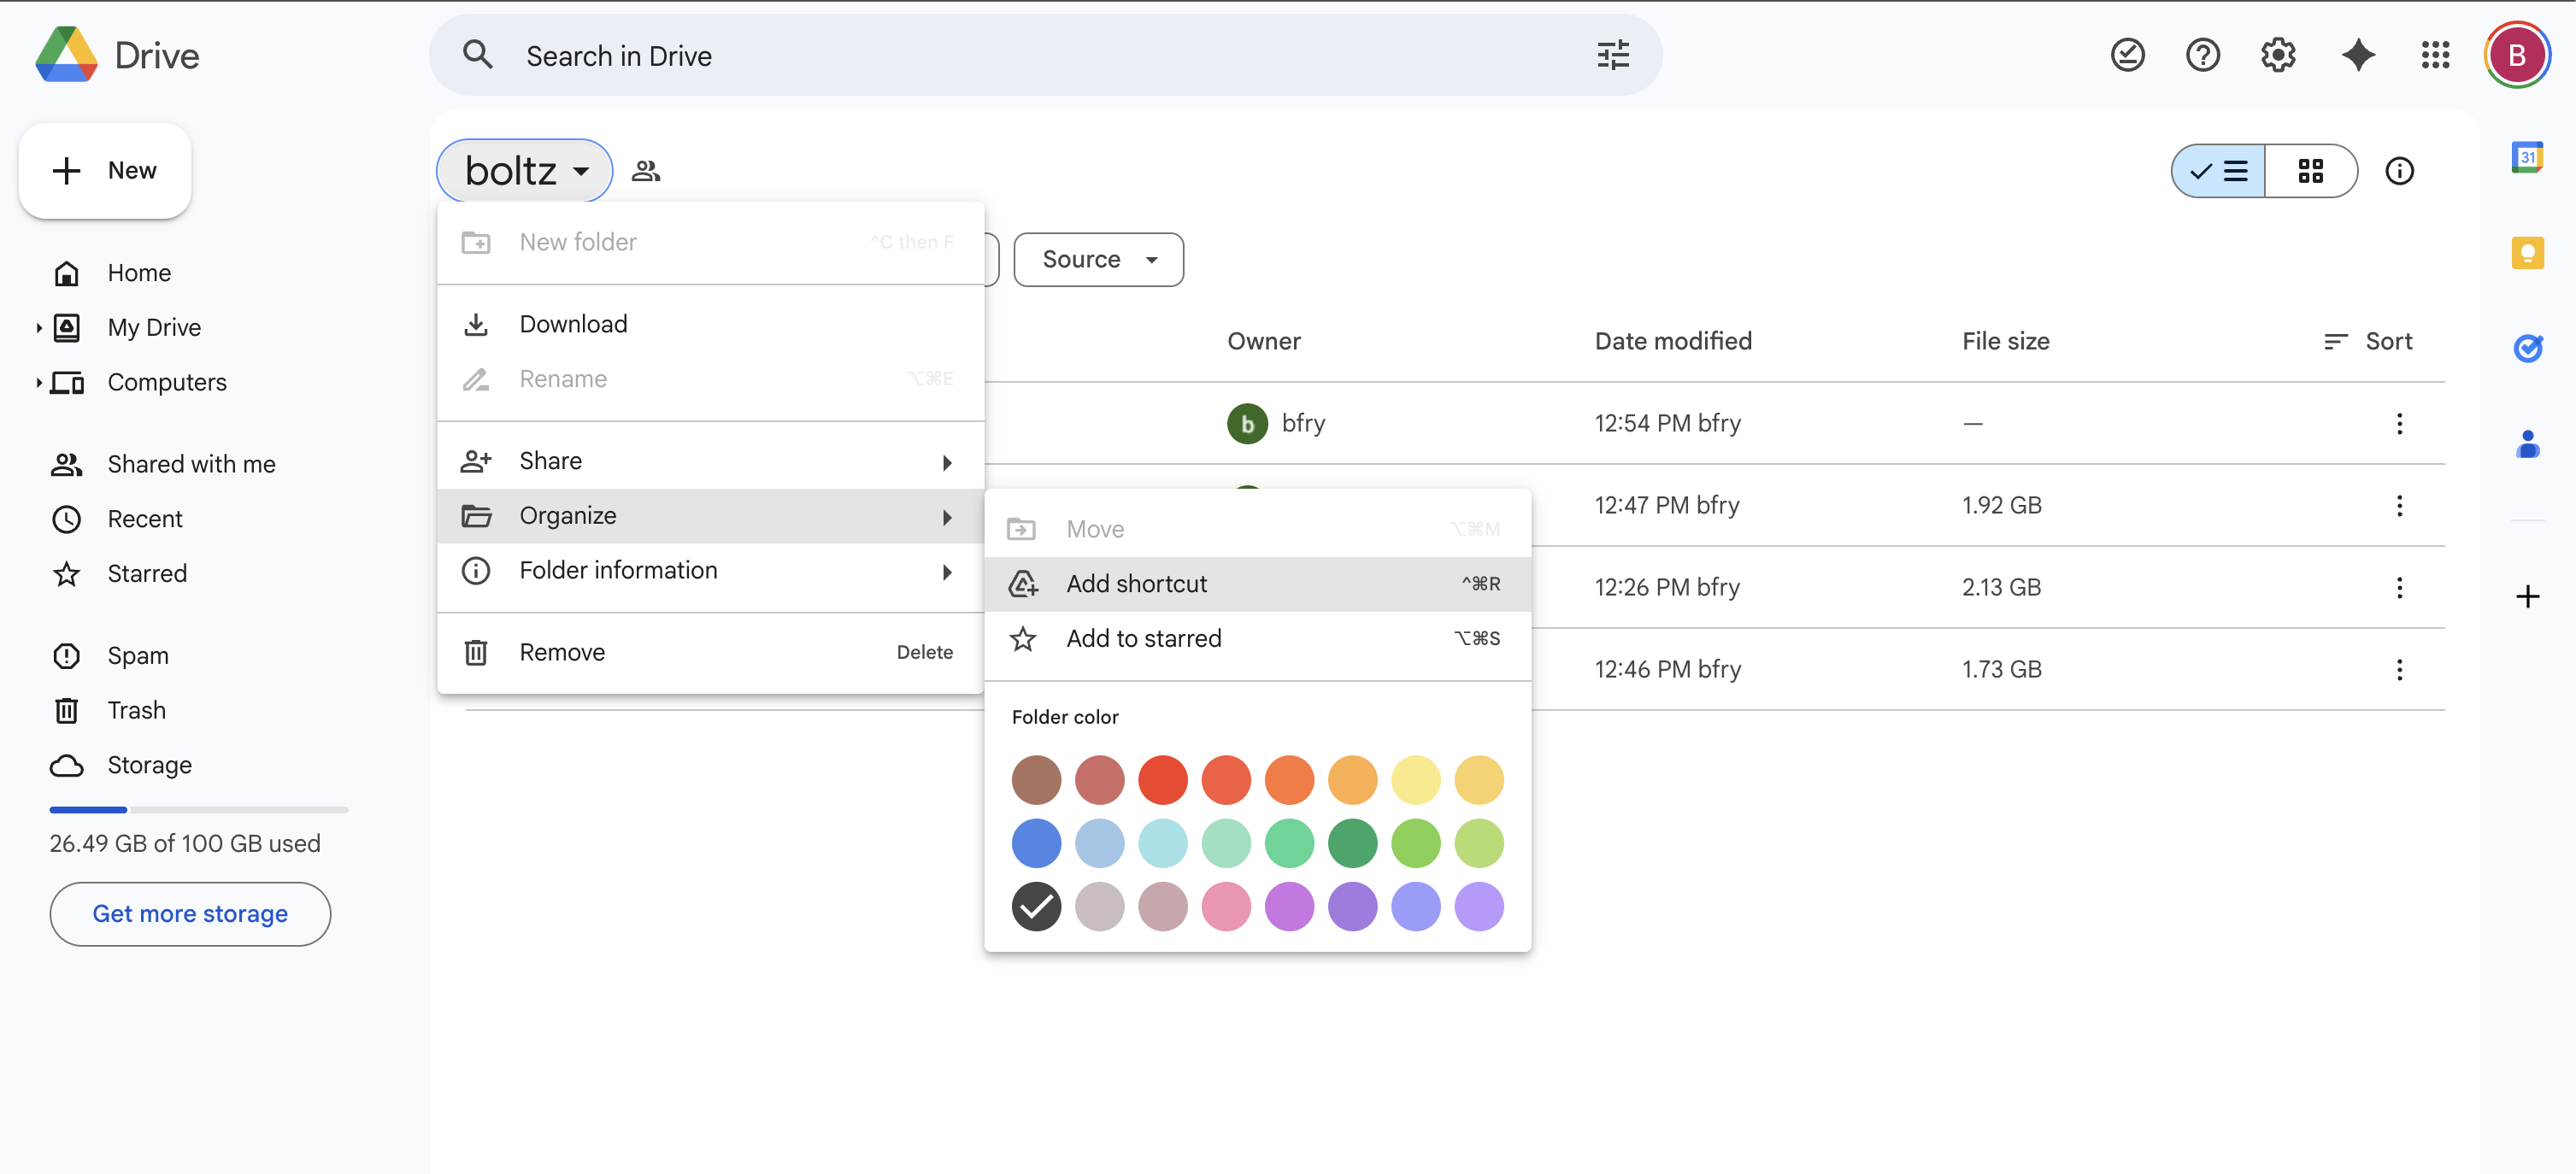

### Step 2: Click the `All Locations` tab and select `My Drive`

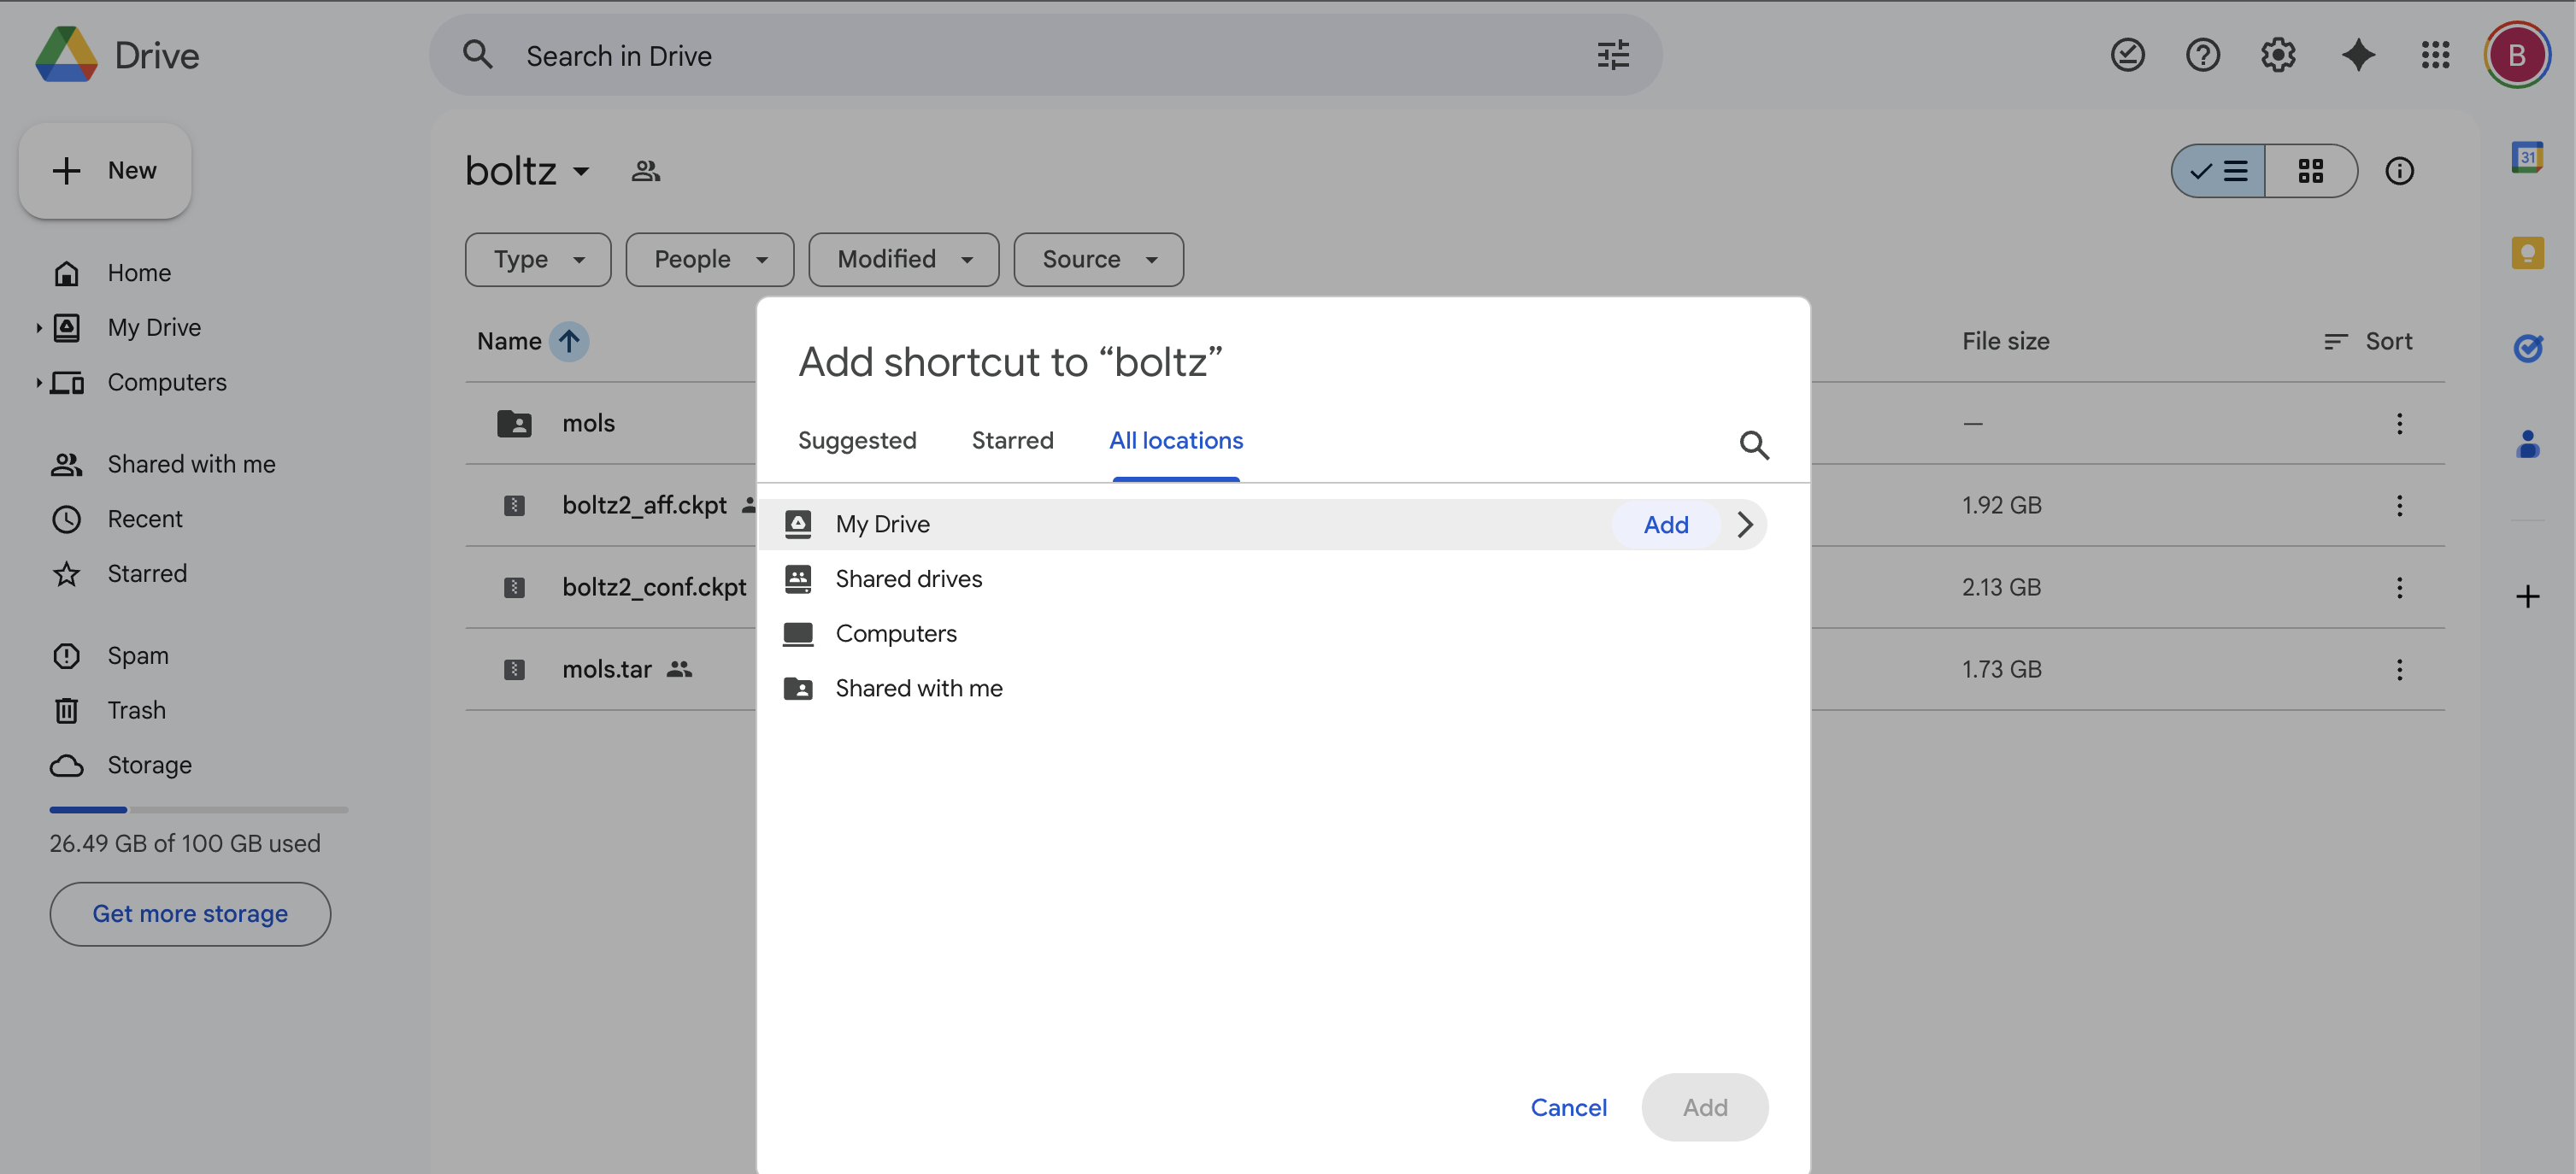


This will make the files in this folder accessible in your Google Colab notebook even though they are not copied to your Google Drive and will not take up space (this is good since they are big files)

___


<mark>***Once the boltz files are linked in your Google Drive, DO NOT HIT THE `Run all` BUTTON.***</mark>


To proceed, run the first cell and wait for the notebook to crash this will install dependencies into the Colab runtime. Once the notebook crashes, the runtime has been restarted with the new dependencies.

Run cells starting from the first cell one at a time until all dependencies are installed.

> There is a bug in Colab where the `Run all` causes the notebook to crash.
___

In [1]:

import os
import re
import subprocess
import sys

# @title ### Install git dependencies and dependencies for colab runtime.

# @markdown <mark>***You will see a popup message saying the session has crash for an unknown reason, this is expected.***</mark>

# @markdown To finish the installation, run the cells one-at-a-time starting from the first cell and the crash should not happen again.
# @markdown If things have gone as expected, you will see a printout below this cell saying dependencies were installed successfully.


try:
  import prody as pr
  print('Dependencies successfully installed!')
except:
  !pip install prody seaborn tqdm rdkit py3Dmol openbabel-wheel freesasa
  os.kill(os.getpid(), 9)


Dependencies successfully installed!


In [2]:
# @title ### Connect to pre-configured Boltz-2x weights through your Google Drive.
from pathlib import Path
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

if not Path('/content/drive/MyDrive/boltz').exists():
    print('You probably didn\'t follow the steps depicted in the images above. You must link the boltz directory linked at the top of the previous cell into your google drive so it can be accessed in this Colab notebook. Once you have done this, hit runtime -> Disconnect and delete runtime, then hit runall again.')
    raise NotImplementedError

Mounted at /content/drive/


In [3]:
# @title Install NISE from GitHub
import prody as pr
import py3Dmol

!git clone https://github.com/polizzilab/NISE.git --depth 1
!cd NISE; git submodule update --init --recursive

Cloning into 'NISE'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 21 (delta 2), reused 11 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (21/21), 25.95 MiB | 18.92 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Submodule 'LASErMPNN' (https://github.com/polizzilab/LASErMPNN.git) registered for path 'LASErMPNN'
Submodule 'LigandMPNN' (https://github.com/dauparas/LigandMPNN.git) registered for path 'LigandMPNN'
Cloning into '/content/NISE/LASErMPNN'...
Cloning into '/content/NISE/LigandMPNN'...
Submodule path 'LASErMPNN': checked out '0be50b3009b971f6b1d8a93121bc545ba7327a0d'
Submodule path 'LigandMPNN': checked out '26ec57ac976ade5379920dbd43c7f97a91cf82de'


In [4]:
# @title ### Install LASErMPNN and Boltz dependencies as separate python installation. (~2 mins)
# @markdown LASErMPNN and Boltz-2 are being installed into a virtual environment separate from the Colab runtime.
# @markdown This makes it possible to install their dependencies without conflicts with Colab's dependencies.
import os
import re
import subprocess
import sys

venv_dir = ".venv"
venv_py = os.path.join(venv_dir, "bin", "python")

# 1) Create virtualenv if needed
if not os.path.isdir(venv_dir):
    subprocess.check_call(["uv", "venv", venv_dir])

print("Venv python:", venv_py)

# 2) Install base stack into the venv with uv, including pip itself
env = os.environ.copy()
env["UV_PYTHON"] = venv_py

subprocess.check_call(
    [
        "uv", "pip", "install",
        "pip",                # put pip into the venv
        "torch==2.8.0",
        "numpy<2.0.0",
        "scipy",
        "pandas",
        "scikit-learn",
        "h5py",
        "pytest",
        "prody",
        "matplotlib",
        "rdkit-to-params",
        "seaborn",
        "jupyter",
        "plotly",
        "pykeops",
        "logomaker",
        "wandb",
        "tqdm",
        "rdkit",
        "py3Dmol",
        "openbabel-wheel",
        "boltz[cuda]==2.2.1",
        "freesasa",
    ],
    env=env,
)

# 3) Inside the venv: detect torch CUDA + install matching PyG wheels with pip -f
pyg_install_code = r"""
import re
import sys
import subprocess
import torch

print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("Torch CUDA runtime version:", torch.version.cuda)

m = re.match(r"^(\d+\.\d+\.\d+)(\+cu\d+)?", torch.__version__)
if not m:
    raise SystemExit(f"Unexpected torch version: {torch.__version__}")

base_version, cuda_suffix = m.groups()
cuda_suffix = cuda_suffix or ""

if cuda_suffix:
    pyg_url = f"https://data.pyg.org/whl/torch-{base_version}{cuda_suffix}.html"
else:
    pyg_url = f"https://data.pyg.org/whl/torch-{base_version}+cpu.html"

print("Using PyG wheel index:", pyg_url)

subprocess.check_call([
    sys.executable, "-m", "pip", "install",
    "torch_scatter",
    "torch_cluster",
    "-f", pyg_url,
])

print("All installs completed in venv:", sys.executable)
"""

subprocess.check_call([venv_py, "-c", pyg_install_code])

print("Done. Use this Python:", venv_py)

!./.venv/bin/python -c "import torch, torch_scatter; print(torch.__version__); print(torch.cuda.is_available())"

Venv python: .venv/bin/python
Done. Use this Python: .venv/bin/python
2.8.0+cu128
True


In [5]:
# @title ### Configure packages
import sys
import logging
import numpy as np
import prody as pr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

pr.confProDy(verbosity='none')
logging.basicConfig(level=logging.DEBUG, filename='app.log', force=True)
logging.getLogger("prody").setLevel(logging.WARNING)

@> ProDy is configured: verbosity='none'
INFO:.prody:ProDy is configured: verbosity='none'


# 1) Upload input structure

In [6]:
# @title Upload an input PDB file to optimize with NISE.

import os
from google.colab import files
import prody as pr
from pathlib import Path
import shutil

nise_trajpath = Path('./nise_trajectory/input_backbones/')

# @markdown Whether to delete the contents of a previous trajectory output directory if this cell is rerun. Default is True. Set to False to make sure you don't accidentally delete output you want to keep if you rerun the cell.
delete_prev = True #@param {type:"boolean"}

if nise_trajpath.parent.exists() and delete_prev:
  print('Deleting previous NISE trajectory.')
  shutil.rmtree(nise_trajpath)

nise_trajpath.mkdir(exist_ok=False, parents=True)

# @markdown Optionally, use an example PDB (apixaban in NTF2 fold).
# @markdown <mark>If not checked, see upload prompt in cell output below after executing it.</mark>
use_example_pdb = True #@param {type:"boolean"}

if not use_example_pdb:

  def upload_files():
    upload_dict = files.upload()

    # Get the path to what was uploaded
    pdb_string = upload_dict[list(upload_dict.keys())[0]]
    ipath = (Path('/content/') / list(upload_dict.keys())[0]).absolute()

    # Figure out what type of file it is.
    tmp_opath = Path('/content/temp')
    for suffix in ipath.suffixes:
      tmp_opath = tmp_opath.with_suffix(suffix)

    if ''.join(ipath.suffixes) not in ['.pdb', '.cif']:
      raise ValueError(f'File type not supported: {"".join(ipath.suffixes)}')

    shutil.copy(ipath, tmp_opath)
    os.remove(str(ipath.absolute()))

    return tmp_opath


  pdb_path = upload_files()

  print("Upload a .pdb or .cif file encoding your protein complex below.")
  print(Path(pdb_path).absolute().suffixes)

  if '.cif' in Path(pdb_path).suffixes:
    protein = pr.parseMMCIF(str(pdb_path))
  else:
    protein = pr.parsePDB(str(pdb_path))

  opath = Path(pdb_path)
  while opath.suffixes:
    opath = opath.with_suffix('')
  pdb_path = opath.with_suffix('.pdb')
  pr.writePDB(str(nise_trajpath / 'input.pdb'), protein)

else:
  shutil.copy('./NISE/example_pdbs/02_apex_NISE_input-pose_00-seq_0980_model_0_rank_01.pdb', nise_trajpath / 'input.pdb')


### Configure NISE

In [7]:
%%capture
shutil.copy('/content/NISE/run_nise_boltz2x.py', '.')

# @markdown TODO: describe
ligand_smiles = 'COC1=CC=C(C=C1)N2C3=C(CCN(C3=O)C4=CC=C(C=C4)N5CCCCC5=O)C(=N2)C(=O)N' # @param {type: "string"}
# @markdown TODO: describe
protein_self_consistency_threshold = 2.0 # @param {type: "number"}
# @markdown TODO: describe
ligand_self_consistency_threshold = 5.0 # @param {type: "number"}
# @markdown TODO: describe
sequences_sampled_per_backbone = 4 # @param [4, 8, 16, 32, 64]
# @markdown TODO: describe
disable_charged_first_shell_residues = True # @param {type: "boolean"}
# @markdown TODO: describe
objective_function = 'ligand_plddt' # @param ['ligand_plddt', 'iptm', 'pbind', 'ligand_plddt_and_pbind', 'iptm_and_pbind']


if ligand_smiles == '' or ligand_smiles is None:
  raise ValueError('Please enter a ligand SMILES string.')

with open('run_nise_boltz2x.py', 'r') as f:
  lines = f.read().strip().split('\n')

  nise_dir_index = -1
  namemain_line = -1
  lines_split = []
  for lidx, line in enumerate(lines):
    if line.startswith('NISE_DIRECTORY_PATH'):
      nise_dir_index = lidx

    if line.startswith('if __name__ =='):
      namemain_line = lidx
      break

    lines_split.append(line)

  lines_split[nise_dir_index] = r"NISE_DIRECTORY_PATH='/content/NISE/'"

colab_content="""laser_sampling_params = {
    'sequence_temp': 0.5, 'first_shell_sequence_temp': 0.7,
    'chi_temp': 1e-6, 'seq_min_p': 0.0, 'chi_min_p': 0.0,
    'disable_pbar': True, 'disabled_residues_list': ['X', 'C'], # Disables cysteine sampling by default.
    # ====================================================================================================
    # Optional: Pass a prody selection string of the form ('resnum 1 or resnum 3 or resnum 5...') to
    # specify residues over which to constrain the sampling of ALA or GLY residues.
    # This string can be generated using './identify_surface_residues.ipynb'
    # ====================================================================================================
    'budget_residue_sele_string': None,
    'ala_budget': 4, 'gly_budget': 0, # May sample up to 4 Ala and 0 Gly over the selected region if not None.
    'disable_charged_fs': DISABLE_CHARGED_FIRST_SHELL_RESIDUES, # Disables sampling D,E,K,R residues for buried residues around the ligand.
}

params = dict(
    debug = (debug := False),
    use_wandb = (use_wandb := False),

    input_dir = Path('/content/nise_trajectory/').resolve(),

    ligand_3lc = 'LIG', # Should match CCD if using reduce.
    ligand_rmsd_mask_atoms = set(), # Atoms to IGNORE in RMSD calculation.
    ligand_atoms_enforce_buried = set(), # Atoms to enforce remain buried inside convex hull when selecting new backbones.
    ligand_atoms_enforce_exposed = set(), # Atoms to enforce remain exposed relative to the convex hull when selecting new backbones. I would suggest only using this for linker regions attached to your ligand or clearly exposed charged polar groups.
    laser_sampling_params = laser_sampling_params,
    ligand_smiles = 'SMILES_PLACEHOLDER',

    objective_function = (objective_function := 'OBJECTIVE_FUNCTION_PLACEHOLDER'), # Current options: {'ligand_plddt', 'iptm', 'pbind', 'ligand_plddt_and_pbind', 'iptm_and_pbind'}, Check the top of the file for implemented strategies, if you find an alternative strategy to work well please make a git commit so others can test it out as well!
    drop_rmsd_mask_atoms_from_ligand_plddt_calc = True,
    keep_input_backbone_in_queue = False,
    keep_best_generator_backbone = True, # The highest scoring pose may not necessarily generate higher scoring poses, keeps the pose that has generated the best poses after the first iteration in the queue if not already the best scoring pose.
    rmsd_use_chirality = False, # Will fail to compute RMSD on mismatched chirality ligands, might be bugged...
    self_consistency_ligand_rmsd_threshold = SELF_CONSISTENCY_LIGAND_RMSD_THRESHOLD,
    self_consistency_protein_rmsd_threshold = SELF_CONSISTENCY_PROTEIN_RMSD_THRESHOLD,

    align_on_binding_site = False, # If align on binding site is True, protein RMSD (and self_consistency_protein_rmsd_threshold above) becomes binding site RMSD. Useful if you have a large protein with floppy regions away from the ligand. Binding site is computed as residues with sidechain atoms within 5.0A of the ligand in the lasermpnn output structure.
    fixed_identity_residue_indices = None, # An optional prody selection string of the form "resindex 0 2 3 4 5" or "resnum 1 3 5"...

    use_reduce_protonation = False, # If False, will use RDKit to protonate, these hydrogens will not preserve the input names and aren't placed conditioned on the sidechains but REDUCE sometimes drops hydrogens if geometry changes outside of expected bounds.
    reduce_hetdict_path = None, # Can set to None if use_reduce_protonation False
    reduce_executable_path = None, # Can set to None if use_reduce_protonation False

    model_checkpoint = Path('/content/NISE/LASErMPNN/model_weights/laser_weights_0p1A_noise_ligandmpnn_split.pt'),

    num_iterations = 100,
    num_top_backbones_per_round = 3,
    sequences_sampled_at_once = 30,

    boltz2x_executable_path = '/content/.venv/bin/boltz',
    boltz_inference_devices = (boltz_inference_devices := ['cuda:0',]),
    use_boltz_conformer_potentials = True, # Use Boltz-x mode, this is almost always better.
    boltz2_predict_affinity = True if ('pbind' in objective_function) else False,
    use_boltz_1x = False, # Run the same script using --model boltz-1, multi-device inference with this seems bugged with boltz v2.1.1
    boltz2_disable_kernels = False, # Disables cuEquivariance kernels, this is likely not necessary.
    boltz2_disable_nccl_p2p = False, # On some systems with certain graphics cards, NCCL can hang indefinitely. This flag fixes this issue allowing running boltz / NISE with multiple GPUs. https://github.com/NVIDIA/nccl/issues/631

    sequences_sampled_per_backbone = SEQUENCES_SAMPLED_PER_BACKBONE if not debug else 1 * len(boltz_inference_devices),
    burial_mask_alpha_hull_alpha = 9.0, # Set to a larger number for folds with wider pockets (ex: 7-helix bundle) (Ex: 100.0), see https://github.com/benf549/CARPdock/blob/main/visualize_hull.ipynb

    laser_inference_device = boltz_inference_devices[0],
    laser_inference_dropout = True,
)
if use_wandb:
    wandb.init(project='design-campaigns', entity='benf549', config=params)
main(**params)
"""

lines_split.extend(
    colab_content.strip(
  ).replace('SMILES_PLACEHOLDER', ligand_smiles).split(
    '\n'
    ).replace('SELF_CONSISTENCY_LIGAND_RMSD_THRESHOLD', str(ligand_self_consistency_threshold)
    ).replace('SELF_CONSISTENCY_PROTEIN_RMSD_THRESHOLD', str(protein_self_consistency_threshold)
    ).replace('SEQUENCES_SAMPLED_PER_BACKBONE', str(sequences_sampled_per_backbone)
    ).replace('DISABLE_CHARGED_FIRST_SHELL_RESIDUES', str(disable_charged_first_shell_residues)
    ).replace('OBJECTIVE_FUNCTION_PLACEHOLDER', str(objective_function))
)

with open('run_nise_boltz2x.py', 'w') as f:
  f.write('\n'.join(lines_split))

AttributeError: 'list' object has no attribute 'replace'

In [8]:
!./.venv/bin/python run_nise_boltz2x.py

Traceback (most recent call last):
  File "/content/run_nise_boltz2x.py", line 30, in <module>
    from LASErMPNN.run_inference import load_model_from_parameter_dict # type: ignore
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ModuleNotFoundError: No module named 'LASErMPNN'
